In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from time import sleep 
import open3d as o3d
import numpy as np
import k4a
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = k4a.Device.open()

device_config = k4a.DeviceConfiguration(
    color_format=k4a.EImageFormat.COLOR_BGRA32,
    color_resolution=k4a.EColorResolution.RES_720P,
    depth_mode=k4a.EDepthMode.WFOV_2X2BINNED,
    camera_fps=k4a.EFramesPerSecond.FPS_5
)
device.start_cameras(device_config)

<EWaitStatus.SUCCEEDED: 0>

In [3]:
cal = device.get_calibration(
    depth_mode=device_config.depth_mode,
    color_resolution=device_config.color_resolution
)

trans = k4a.Transformation(cal)

In [4]:
intrinsics = cal.depth_cam_cal.intrinsics.parameters.param
print(intrinsics.fx, intrinsics.fy, intrinsics.cx, intrinsics.cy)

251.63742065429688 251.6957550048828 255.9892578125 259.73980712890625


In [5]:
capture = device.get_capture(-1)

color = capture.color
depth = capture.depth

In [6]:
depth_t = trans.depth_image_to_color_camera(depth)

cloud = trans.depth_image_to_point_cloud(depth, k4a.ECalibrationType.DEPTH).data.reshape(-1,3)

In [7]:
# def plot_images(*imgs):
#     fig = plt.figure()
#     cnt = len(imgs)
#     ax = [fig.add_subplot(1, cnt, i+1, label=str(i)) for i in range(cnt)]

#     im = [ax[0].imshow(image1.data)]
#     im.append()
#     im.append(ax[1].imshow(image2.data, cmap='jet'))

#     if len(cmap) == 0:
#         im.append(ax[2].imshow(image3.data))
#     else:
#         im.append(ax[2].imshow(image3.data, cmap=cmap))

#     ax[0].title.set_text('Color')
#     ax[1].title.set_text('Depth')
#     ax[2].title.set_text('Transformed Image')

#     plt.show()

def plot_images(image1:k4a.Image, image2:k4a.Image, image3:k4a.Image, cmap:str=''):

    # Create figure and subplots.
    fig = plt.figure()
    ax = []
    ax.append(fig.add_subplot(1, 3, 1, label="Color"))
    ax.append(fig.add_subplot(1, 3, 2, label="Depth"))
    ax.append(fig.add_subplot(1, 3, 3, label="IR"))

    # Display images.
    im = []
    im.append(ax[0].imshow(image1.data))
    im.append(ax[1].imshow(image2.data, cmap='jet'))

    if len(cmap) == 0:
        im.append(ax[2].imshow(image3.data))
    else:
        im.append(ax[2].imshow(image3.data, cmap=cmap))


    # Create axes titles.
    ax[0].title.set_text('Color')
    ax[1].title.set_text('Depth')
    ax[2].title.set_text('Transformed Image')

    plt.show()

<IPython.core.display.Javascript object>


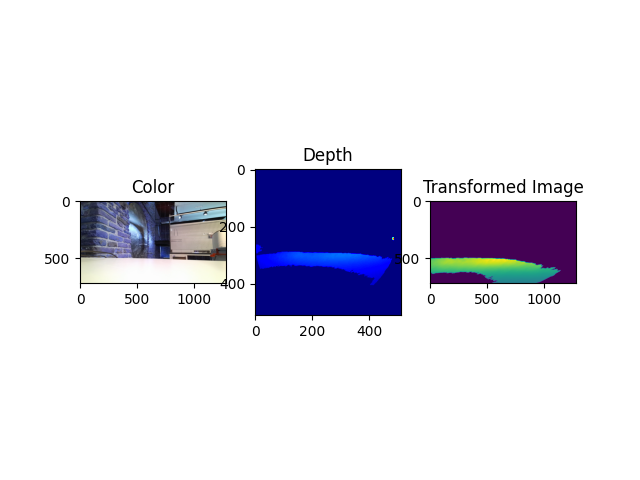

In [8]:
plot_images(color, depth, depth_t)

In [9]:
from tempfile import NamedTemporaryFile, TemporaryDirectory
from subprocess import run
from time import sleep

def get_planes(img_color, img_depth):
    with NamedTemporaryFile('w', suffix='.jpg', delete=False) as c_file, \
    NamedTemporaryFile('w', suffix='.png', delete=False) as d_file, \
    TemporaryDirectory() as res_dir:
        cv2.imwrite(c_file.name, img_color)
        cv2.imwrite(d_file.name, img_depth)
        res = run(["/home/main/RGBDPlaneDetection/build/RGBDPlaneDetection", c_file.name, d_file.name, res_dir], capture_output=True)
        if res.returncode != 0:
            return None
        
        res_img = cv2.imread(res_dir + "/0-plane.png")
        
        with open(res_dir + "/0-plane-label.txt", 'r') as f: 
            n = int(f.readline())
            res_labels = np.array([[int(j) for j in i.split()] for i in f.readlines()])

        with open(res_dir + "/0-plane-data.txt", 'r') as f:
            _ = f.readline()
            res_data = [{
                "i": int(i[0]),
                "color": np.array([int(j) for j in i[2:5]]),
                "normal": np.array([float(j) for j in i[5:8]]),
                "center": np.array([float(j) for j in i[8:11]])
            } for i in [f.readline().split() for _ in range(n)]]

        return res_img, res_labels, res_data

<IPython.core.display.Javascript object>


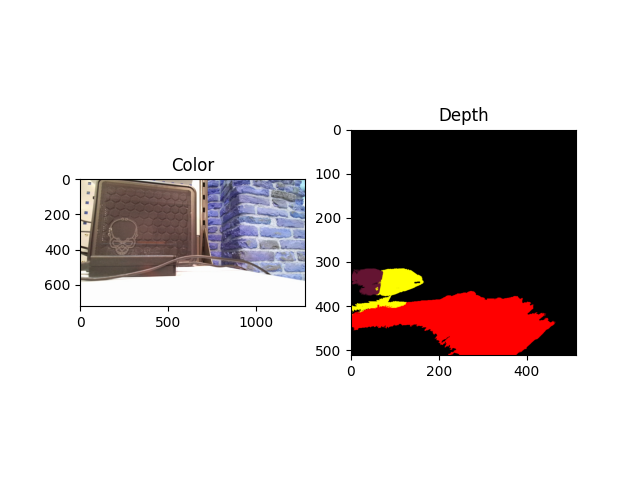

KeyboardInterrupt: 

In [10]:
fig = plt.figure()
ax = []
ax.append(fig.add_subplot(1, 2, 1, label="Color"))
ax.append(fig.add_subplot(1, 2, 2, label="Depth"))

im = []
im.append(ax[0].imshow(capture.color.data))
im.append(ax[1].imshow(capture.depth.data))#, cmap='jet'))

ax[0].title.set_text('Color')
ax[1].title.set_text('Depth')

from time import time

while fig is not None:
    t = time()
    capture = device.get_capture(-1)
    if capture is None:
        del fig
        break
    
    depth_t = trans.depth_image_to_color_camera(capture.depth).data
    res_img, res_labels, res_data = get_planes(capture.color.data, depth_t)
    
    im[0].set_data(capture.color.data)
    im[1].set_data(res_img)
#     im[2].set_data(capture.ir.data)
    
    fig.canvas.draw()
#     print(time() - t)
#     sleep(0.01)

In [ ]:
pc = 

In [11]:
device.stop_cameras()